In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import pdb


In [2]:
# load image data
mnist_load = pd.read_csv('../toy_data/mnist.csv')
mnist = mnist_load.drop(columns='label')/255
print(mnist.shape)
data = mnist

(60000, 784)


In [3]:
# split training and testing data
labels = mnist_load.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, random_state=0)

Text(0.5, 1.0, 'PCA explained variance ratio')

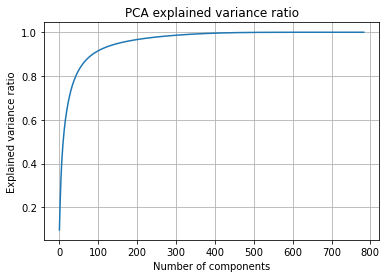

In [4]:

# pca = PCA(n_components=data.shape[1])
# pca.fit(data)
pca = IncrementalPCA(n_components=X_train.shape[1])
pca.fit(X_train)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('PCA explained variance ratio')

In [5]:
# get best number of components
n_comp_pca = 60

# apply PCA with reduced number of components
pca_red = IncrementalPCA(n_components=n_comp_pca)
X_train_pca_red = pca_red.fit_transform(X_train)
X_test_pca_red = pca_red.transform(X_test)
X_train_pca_recovered = pca_red.inverse_transform(X_train_pca_red)
print(X_train_pca_red.shape)

(48000, 60)


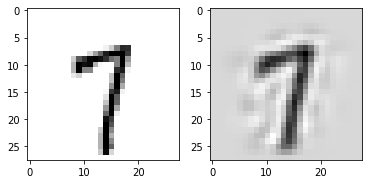

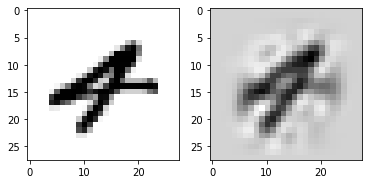

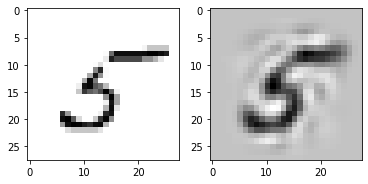

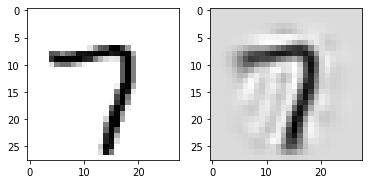

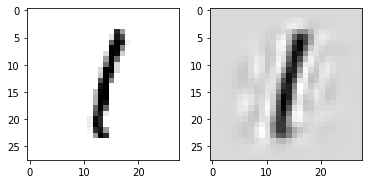

In [6]:
# compare original and compressed images
for i in range(0, 5):
    f, axarr = plt.subplots(1, 2)
    img_pca = X_train_pca_recovered[i,:].reshape((28, 28))
    img_orig = X_train.iloc[i].values.reshape((28, 28))    
    axarr[0].imshow(img_orig, cmap='gray_r')
    axarr[1].imshow(img_pca, cmap='gray_r')

In [7]:
# k means clustering
# set k at 10 to match number of labels
k = 200
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0).fit(X_train_pca_red)
# kmeans = KMeans(n_clusters=k, random_state=0).fit(data)

# associate kmeans clusters with labels
y_train_pred = kmeans.labels_
reference_labels = {}
print(len(np.unique(y_train_pred)))
for i in np.unique(y_train_pred):    
    index = np.where(y_train_pred == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()    
    reference_labels[i] = num

# use clusters on test data
y_test_pred = kmeans.predict(X_test_pca_red)

# apply relabeling
for i in range(0, len(y_train_pred)):
    y_train_pred[i] = reference_labels[y_train_pred[i]]
for i in range(0, len(y_test_pred)):
    y_test_pred[i] = reference_labels[y_test_pred[i]]

200


In [8]:
def metrics_kmeans(y_pred, y_true):    
    #@TODO: roc_auc score
    kmeans_accuracy = accuracy_score(y_pred, y_true)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    return kmeans_accuracy, cm

training accuracy: 0.8955625, testing accuracy 0.8999166666666667


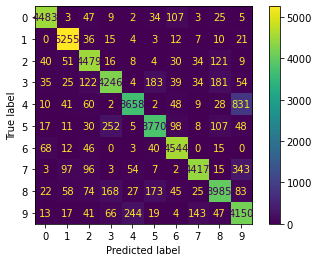

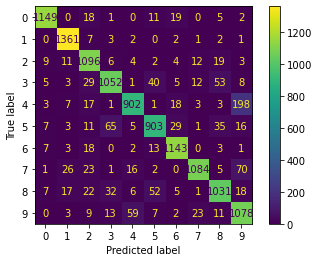

In [9]:
# create confusion matrix from kmeans results
# training accuracy

kmeans_acc_train, cm_train = metrics_kmeans(y_train_pred, y_train)
kmeans_acc_test, cm_test = metrics_kmeans(y_test_pred, y_test)

print('training accuracy: {}, testing accuracy {}'.format(kmeans_acc_train, kmeans_acc_test))
